# Imports and parameters

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import torch
import shutil
import sys
import urllib.request

from diffusers import DDIMScheduler, DiffusionPipeline, StableDiffusionPipeline, DPMSolverMultistepScheduler
from pathlib import Path
from PIL import Image
from torchvision.utils import save_image
from tqdm import tqdm
from typing import Optional

/Users/robdewit/Documents/text2image/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def find_project_root() -> Optional[Path]:
    current = Path(".").resolve()
    
    while True:
        if (current / ".git").exists():
            return current
        
        if current.parent == current:
            print("WARNING: No .git dir found")
            return current
              
        current = current.parent
        

PROJECT_ROOT = find_project_root()

## Parameters

In [10]:
# Model
MODEL_DIRECTORY = 'models'
BASE_MODEL = 'runwayml/stable-diffusion-v1-5'

# Pokemon of interest
TARGET_POKEMON_TYPE = 'all'

# LoRA
EXTERNAL_DATA_PATH = 'data/external'
TRAIN_DATA_PATH = 'data/processed/pokemon'
TARGET_POKEMON_TYPE = 'all'
LORA_PATH = f'{MODEL_DIRECTORY}/pkmnlora'
LEARNING_RATE = 1e-4
MAX_TRAIN_STEPS = 500

# Generation
SEED = 9
NUM_INFERENCE_STEPS = 25
BATCH_SIZE = 5
PROMPT = 'a (pkmnlora:1.5) (pokemon), drawn concept art, facing camera, (solid white background:1.2)'
NEGATIVE_PROMPT = 'human, people, person, 3d, computer graphic, black and white, (painting by bad-artist:0.9), watermark, text, error, blurry, jpeg artifacts, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, artist name, (worst quality, low quality:1.4), bad anatomy'
OUTPUT_DIRECTORY = 'outputs'

# Clone diffusers repo, install requirements, run config

In [ ]:
%%bash -s "$PROJECT_ROOT"

export PROJECT_ROOT=$1

# NEED TO RUN THESE ONCE
git clone --depth 1 --branch v0.14.0 https://github.com/huggingface/diffusers.git $PROJECT_ROOT/diffusers
pip3.10 install -r "${PROJECT_ROOT}/diffusers/examples/dreambooth/requirements.txt"
accelerate config default

# Collect Pokémon images and dataset

In [ ]:
# Create directory and clear if it already exists
if not os.path.exists(PROJECT_ROOT / EXTERNAL_DATA_PATH / 'pokemon'):
    os.mkdir(PROJECT_ROOT / EXTERNAL_DATA_PATH / 'pokemon')
else:
    shutil.rmtree(PROJECT_ROOT / EXTERNAL_DATA_PATH / 'pokemon')
    os.mkdir(PROJECT_ROOT / EXTERNAL_DATA_PATH / 'pokemon')

for i in tqdm(range(1, 1009)):
    id = str(i)
    while len(id) < 3:
        id = "0" + id

    imgURL = f"https://assets.pokemon.com/assets/cms2/img/pokedex/full/{id}.png"
    urllib.request.urlretrieve(imgURL, f"{PROJECT_ROOT}/{EXTERNAL_DATA_PATH}/pokemon/{id}.png")

In [ ]:
# Download stats dataset with Kaggle API, make sure ~/.kaggle/kaggle.json exists
# Or manually: https://www.kaggle.com/datasets/05bffa9809b39a7ddc851d80104b1fa314e4ef36700ce74a2c91d8b3c8113112?select=Pokedex_Cleaned.csv

In [ ]:
%%bash -s "$PROJECT_ROOT" "$EXTERNAL_DATA_PATH"

export PROJECT_ROOT=$1
export EXTERNAL_DATA_PATH=$2

kaggle datasets download -d brdata/complete-pokemon-dataset-gen-iiv -f Pokedex_Cleaned.csv -p $PROJECT_ROOT/$EXTERNAL_DATA_PATH

# Get subset of relevant Pokémon

In [ ]:
pokemon = pd.read_csv(PROJECT_ROOT / EXTERNAL_DATA_PATH / 'Pokedex_Cleaned.csv', encoding='latin-1', engine='python')
pokemon = pokemon[["#", "Name", "Primary Type", "Secondary Type"]]

pokemon.head()

if not TARGET_POKEMON_TYPE.lower() in ['all', 'none', '']:
    subset_1 = pokemon.loc[pokemon['Primary Type'].lower() == TARGET_POKEMON_TYPE]
    subset_2 = pokemon.loc[pokemon['Secondary Type'].lower() == TARGET_POKEMON_TYPE]
    
    subset = pd.concat([subset_1, subset_2]).sort_values('pokedex_number')
else:
    subset = pokemon
    
subset.head()

# Resize training images to desired resolution

In [ ]:
# Create directory and clear if it already exists
if not os.path.exists(PROJECT_ROOT / TRAIN_DATA_PATH):
    os.mkdir(PROJECT_ROOT / TRAIN_DATA_PATH)
else:
    shutil.rmtree(PROJECT_ROOT / TRAIN_DATA_PATH)
    os.mkdir(PROJECT_ROOT / TRAIN_DATA_PATH)
          
# Resize training images and save to processed directory
for image_name in os.listdir(PROJECT_ROOT/EXTERNAL_DATA_PATH/'pokemon'):
    
    # Only keep sprites of our defined subset (e.g. water type generation 1)
    pokedex_number = int(image_name.split('.')[0])
    
    if pokedex_number in list(subset['#']):
        pokemon_sprite = Image.open(PROJECT_ROOT/ EXTERNAL_DATA_PATH / 'pokemon' / image_name)
        pokemon_sprite_resized = pokemon_sprite.resize((512, 512))

        # Add leading zeroes
        while len(image_name) < 8:
            image_name = "0" + image_name

        pokemon_sprite_resized.save(PROJECT_ROOT / TRAIN_DATA_PATH / image_name)


# Train LoRA

In [ ]:
%%bash -s "$PROJECT_ROOT" "$BASE_MODEL" "$TRAIN_DATA_PATH" "$LORA_PATH" "$LEARNING_RATE" "$MAX_TRAIN_STEPS"

export PROJECT_ROOT=$1
export BASE_MODEL=$2
export TRAIN_DATA_PATH=$3
export LORA_PATH=$4
export LEARNING_RATE=$5
export MAX_TRAIN_STEPS=$6

# --mps needed for Mac M1+
accelerate launch --mps "${PROJECT_ROOT}/diffusers/examples/dreambooth/train_dreambooth_lora.py" \
  --pretrained_model_name_or_path=$BASE_MODEL  \
  --instance_data_dir=$PROJECT_ROOT/$TRAIN_DATA_PATH \
  --output_dir=$PROJECT_ROOT/$LORA_PATH \
  --instance_prompt="a pkmnlora pokemon" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=100 \
  --learning_rate=$LEARNING_RATE \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=$MAX_TRAIN_STEPS \
  --validation_prompt="a pkmnlora pokemon with green eyes" \
  --validation_epochs=50 \
  --seed="0"

In [ ]:
# accelerate launch --mps "diffusers/examples/dreambooth/train_dreambooth_lora.py" \
#   --pretrained_model_name_or_path='runwayml/stable-diffusion-v1-5' \
#   --instance_data_dir='data/processed/pokemon' \
#   --output_dir='models/test1' \
#   --instance_prompt="a drawing of a pokemon" \
#   --resolution=512 \
#   --train_batch_size=1 \
#   --gradient_accumulation_steps=1 \
#   --checkpointing_steps=100 \
#   --learning_rate=1e-4 \
#   --lr_scheduler="constant" \
#   --lr_warmup_steps=0 \
#   --max_train_steps=300 \
#   --validation_prompt="a drawing of a pokemon" \
#   --validation_epochs=50 \
#   --seed="0" \
#   --report_to="wandb"

# Set up SD pipeline

In [4]:
pipe = DiffusionPipeline.from_pretrained(BASE_MODEL)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

# These settings work for Apple M1/M2 silicon
# Docs for configuring to your hardware: https://huggingface.co/docs/diffusers/optimization/fp16
pipe.to("mps")

# Recommended if your computer has < 64 GB of RAM
pipe.enable_attention_slicing()

Fetching 15 files: 100%|████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 136178.70it/s]
/Users/robdewit/Documents/text2image/.venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [7]:
# Load LoRA on top of base model weights
pipe.unet.load_attn_procs(PROJECT_ROOT/LORA_PATH)

# Generate images

In [11]:
generator = torch.Generator().manual_seed(SEED)

outputs = pipe(prompt=[PROMPT] * BATCH_SIZE
             , negative_prompt=[NEGATIVE_PROMPT] * BATCH_SIZE
             , generator=generator
             , num_inference_steps=NUM_INFERENCE_STEPS)

100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [03:37<00:00,  8.69s/it]


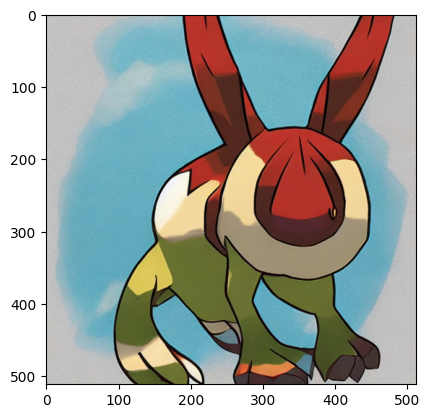

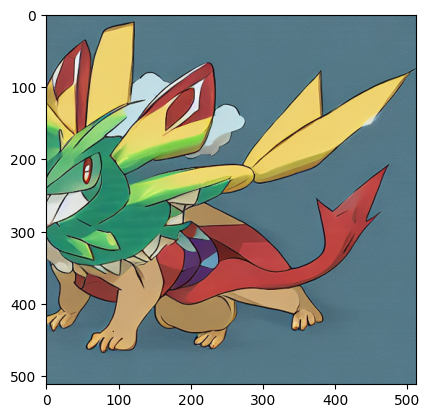

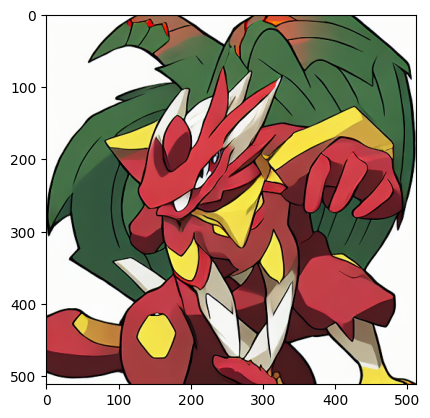

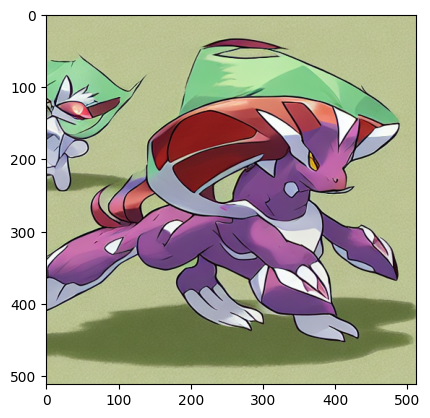

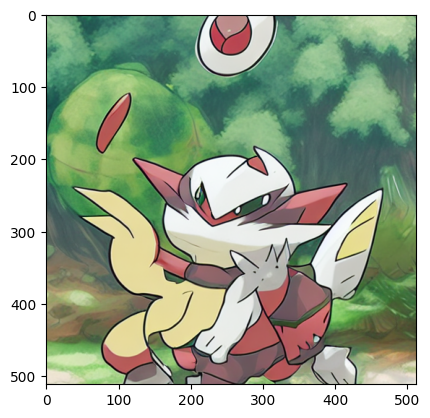

In [12]:
# Create directory and clear if it already exists
if not os.path.exists(PROJECT_ROOT / OUTPUT_DIRECTORY):
    os.mkdir(PROJECT_ROOT / OUTPUT_DIRECTORY)
else:
    shutil.rmtree(PROJECT_ROOT / OUTPUT_DIRECTORY)
    os.mkdir(PROJECT_ROOT / OUTPUT_DIRECTORY)

for i, image in enumerate(outputs.images):
    imgplot = plt.imshow(image)
    plt.show(image)
    
    image.save(f'{PROJECT_ROOT / OUTPUT_DIRECTORY}/{i}.png')